In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from PIL import Image

#warnings
import warnings
warnings.filterwarnings("ignore")

# Libraries for TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
from keras import models, layers
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50
from keras.applications import Xception
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix


print("Importing libraries completed.")

Importing libraries completed.


In [12]:
gpu = tf.config.list_physical_devices('GPU')
gpu

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
data_dir = r"C:\Users\Ven\Desktop\Cash-Counterfeat\model\data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [14]:
# acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['fake_1k', 'fake_500', 'real_1k', 'real_500']


In [15]:
HEIGHT = 300
WIDTH = 400
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50

n_classes = len(class_names)
n_classes

4

In [16]:
img_size = (HEIGHT, WIDTH)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 800 images belonging to 4 classes.


Found 200 images belonging to 4 classes.


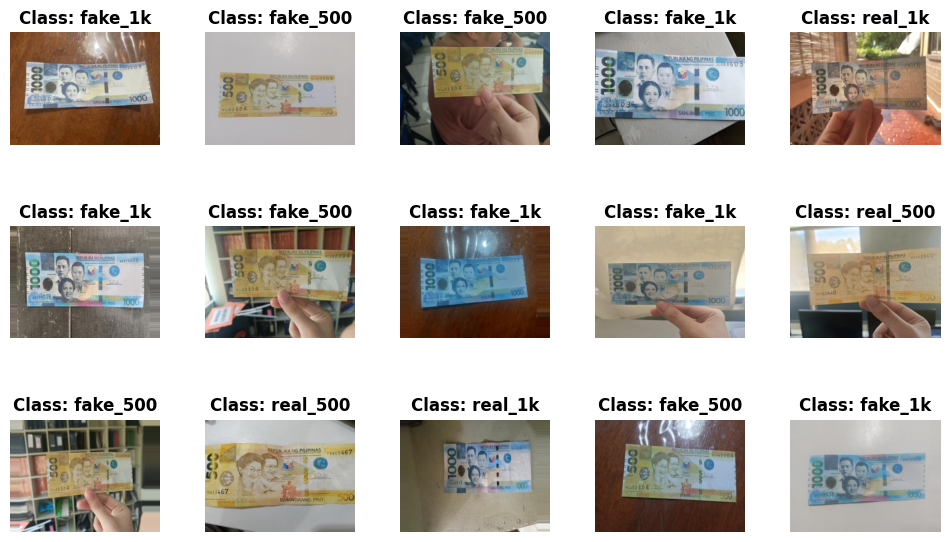

In [17]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    
    # Get the class index from one-hot encoded target
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]
    
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [18]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

In [19]:
# VGG16
input_layer=layers.Input(shape=(HEIGHT,WIDTH,CHANNELS))

# # Create the VGG16 model with your modifications
# base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# # Add custom dense layers with dropout and L2 regularization
# x = base_model.output
# x = layers.Flatten()(x)
# x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = layers.Dropout(0.3)(x)  # Add dropout
# x = layers.Dense(n_classes, activation='softmax')(x)

# model_vgg16 = models.Model(inputs=base_model.input, outputs=x)

model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)
last_layer=model_vgg16.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(n_classes,activation='softmax')(flatten)
model_vgg16=models.Model(inputs=input_layer,outputs=output_layer)

print("We are making all the layers intrainable except the last layer. \n")
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False

We are making all the layers intrainable except the last layer. 



In [20]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tfa.metrics.F1Score(num_classes=n_classes)]

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [21]:
model_vgg16.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 100, 128)      0     

In [ ]:
model_vgg16.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 100, 128)      0     

In [ ]:
history_vgg = model_vgg16.fit(train_generator,batch_size=BATCH_SIZE,verbose=True,validation_data=test_generator, callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/50
50/50 [==============================] - 53s 782ms/step - loss: 3.6791 - acc: 0.5412 - f1_score: 0.5412 - val_loss: 0.7200 - val_acc: 0.7650 - val_f1_score: 0.7208 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.6663 - acc: 0.8625 - f1_score: 0.8627
Reached accuracy threshold! Terminating training.
50/50 [==============================] - 27s 533ms/step - loss: 0.6663 - acc: 0.8625 - f1_score: 0.8627 - val_loss: 0.0409 - val_acc: 0.9900 - val_f1_score: 0.9900 - lr: 0.0010


In [ ]:
predictions = model_vgg16.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

13/13 [==============================] - 2s 138ms/step
              precision    recall  f1-score   support

     fake_1k       0.98      0.98      0.98        50
    fake_500       1.00      1.00      1.00        50
     real_1k       0.98      0.98      0.98        50
    real_500       1.00      1.00      1.00        50

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



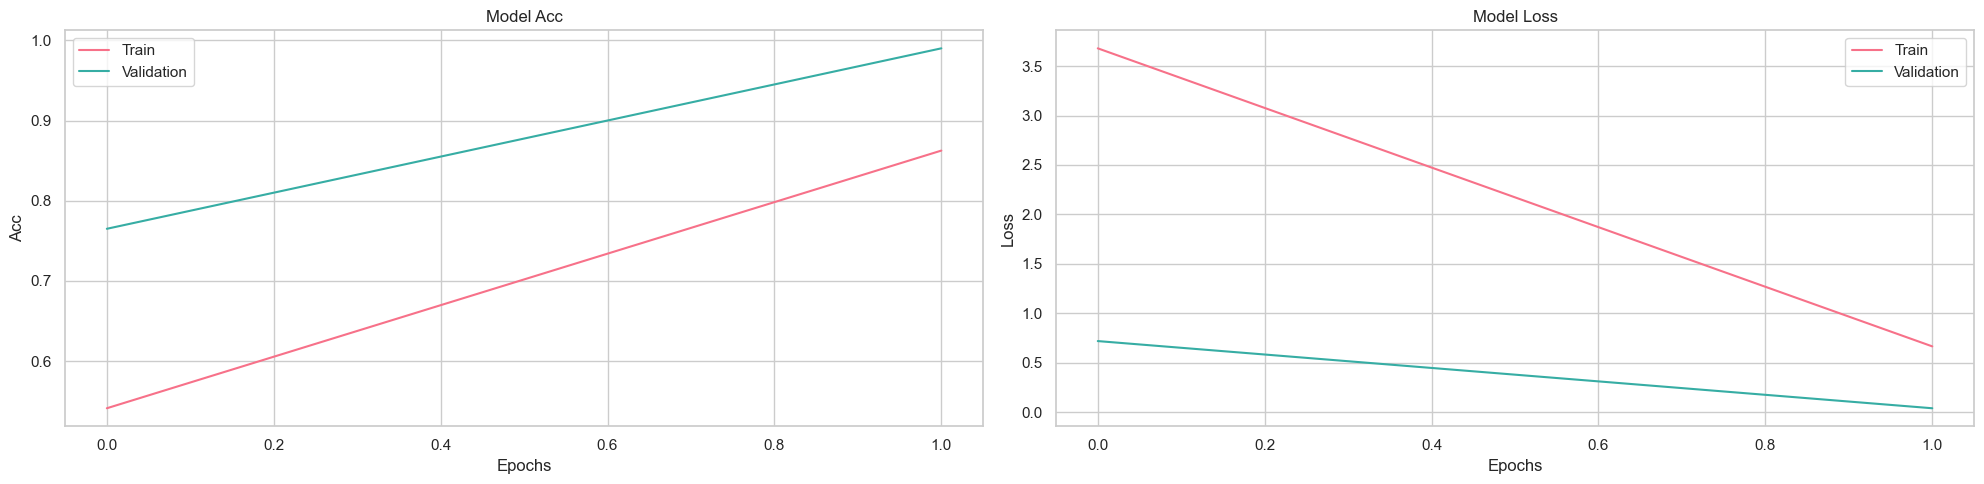

In [ ]:
sns.set(style="whitegrid", rc={"axes.grid": True})

# Create a color palette
palette = sns.color_palette("husl", 2)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

# Loop through metrics
for i, metric in enumerate(["acc", "loss"]):
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history[metric], ax=ax[i], label="Train", color=palette[0])
    sns.lineplot(x=history_vgg.epoch, y=history_vgg.history["val_" + metric], ax=ax[i], label="Validation", color=palette[1])

    ax[i].set_title(f"Model {metric.capitalize()}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric.capitalize())

    ax[i].legend().set_visible(True)

plt.tight_layout()
# plt.savefig('../../server/vgg16/metrics/training')

plt.show()

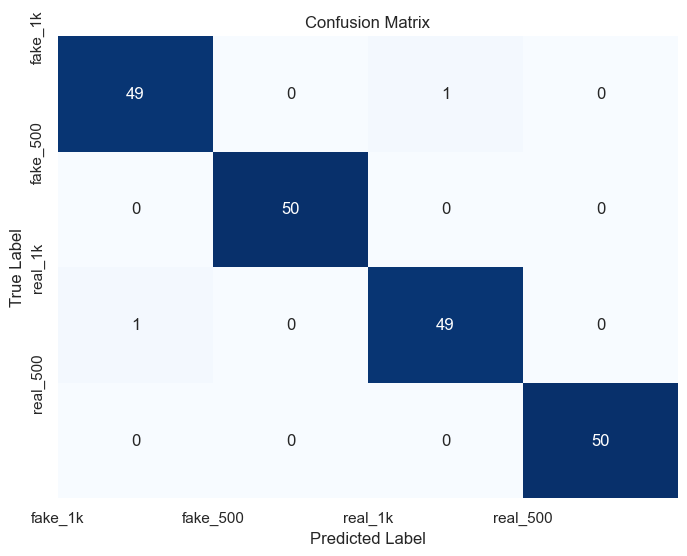

In [27]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=[0, 1, 2, 3], labels=class_names)
plt.yticks(ticks=[0, 1, 2, 3], labels=class_names)
plt.show()


In [25]:
model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\vgg 16 (1000 imgs)\model.json"
model_json = model_vgg16.to_json()
with open(model_path, "w") as json_file:
  json_file.write(model_json)

# model_vgg16.save("vgg16_model.hdf5")

weights_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\vgg 16 (1000 imgs)\model.weights.hdf5"
model_vgg16.save_weights(weights_path)

In [29]:
# Save the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_vgg16)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\vgg 16 (1000 imgs)\tflite\model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmp5kw3skeq\assets


INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmp5kw3skeq\assets
